# This notebook is to test the model of trading based on crossings of the VWAP for different time intervals

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import data_writing
import requests
import config

In [36]:
#functions
def load_bars(timeframe, start_date, end_date):
    symbols = ["DMTK"]
    for symbol in symbols:
        filename = 'data_files/bar_files/{}/{}.txt'.format(timeframe[1:].lower(),symbol)
        f = open(filename, 'w+')
        f.write('date,open,high,low,close,volume\n')
        url = '{}/stocks/{}/bars?start={}&end={}&timeframe={}&limit={}'.format(config.API_DATA_URL, symbol, start_date, end_date, timeframe, 10000)
        r = requests.get(url, headers=config.HEADERS)
        for bar in r.json()['bars']:
            line = '{},{},{},{},{},{}\n'.format(bar['t'], bar['o'], bar['h'], bar['l'], bar['c'], bar['v'])
            f.write(line)

def log_returns(list_prices):
    return np.log(list_prices).diff().fillna(0)

def vwap(df_orig, periods):
    df = df_orig
    df['dollars_traded'] = df['close'] * df['volume']
    df['rolling_vol'] = df.iloc[:,4].rolling(periods, min_periods=1).sum()
    df['rolling_closexvolume'] = df.iloc[:,6].rolling(periods, min_periods=1).sum()
    df["vwap_{}".format(periods)] = df['rolling_closexvolume'] / df['rolling_vol']
    return df.iloc[:,[0,1,2,3,4,5,9]]

def vwap_buy(list_price, list_vwap):
    indicators = []
    for i in range(len(list_price)):
        # if price is greater than or equal to vwap and element before is less than equal to vwap
        if i == 0:
            indicators.append(0)
        elif i == len(list_price)-1 or i == len(list_price)-2:
            indicators.append(-1)
        elif (list_price[i] >= list_vwap[i]) & (list_price[i-1] <= list_vwap[i-1]):
            indicators.append(1)
        elif (list_price[i] <= list_vwap[i]) & (list_price[i-1] >= list_vwap[i-1]):
            indicators.append(-1)
        else:
            indicators.append(0)     
    return indicators 

def calc_vwap_return(df):
    counting = False
    return_sum = 0
    for i in range(len(df)):
        if counting:
            return_sum = return_sum + df['log_returns'][i]
        if df['vwap_indicator'][i] == 1:
            counting = True
        elif df['vwap_indicator'][i] == -1:
            counting=False
        if np.exp(return_sum) <= 0.995:
            break
    return return_sum

def intra_day_returns(df):
    counting = False
    return_sum = 0
    arr = []
    for i in range(len(df)):
        if counting:
            return_sum = return_sum + df['log_returns'][i]
        if df['vwap_indicator'][i] == 1:
            counting = True
        elif df['vwap_indicator'][i] == -1:
            counting=False
        arr.append(return_sum)
    return arr

def reverse_log(value):
    return np.exp(value)

In [48]:
data_writing.load_bars("1Min", "2021-07-21", "2021-07-21")
df = pd.read_csv("C:/Users/Student/Analytics Projects/AlpacaStream/data_files/bar_files/min/AAPL.txt", header=0)
df["date"] = pd.to_datetime(df["date"], utc=True)
df = df.set_index("date")

type(df['close'])

pandas.core.series.Series

In [30]:
df_market = df.between_time('13:30', '20:00')
df_market['log_returns'] = log_returns(df_market['close'])
reverse_log(df_market['log_returns'].sum())

-0.171644352900846

In [39]:
# Putting it all together

def find_best_combo(data):
    vals = np.arange(5, 120, 5)
    rets = []
    for time in vals:
        data_copy = data.copy()
        with_vwap = vwap(data_copy, time)
        with_vwap['vwap_indicator'] = vwap_buy(with_vwap['close'], with_vwap['vwap_{}'.format(time)])
        ret = calc_vwap_return(with_vwap.iloc[10:,:])
        append_val = reverse_log(ret)
        if append_val < 0.995:
            append_val = 0.995
        rets.append(append_val)
    return rets
        #print("{} minute vwap yields: ".format(time), reverse_log(ret))



In [40]:
def list_of_dates(date_object_list):
    a = []
    for d in date_object_list:
        a.append(str(d)[:10])
    return a

def get_all_returns(stock, start_date, end_date):
    dates = list_of_dates(pd.date_range(start_date, end_date))
    returns = np.ones(23)
    five_rets = []
    for date in dates:
        load_bars("1Min", date, date)
        stock_data = pd.read_csv("C:/Users/Student/Analytics Projects/AlpacaStream/data_files/bar_files/min/{}.txt".format(stock), header=0)
        if len(stock_data) == 0:
            continue
        stock_data["date"] = pd.to_datetime(stock_data["date"], utc=True)
        stock_data = stock_data.set_index("date")
        stock_data = stock_data.between_time('13:30', '20:00')
        stock_data['log_returns'] = log_returns(stock_data['close'])
        multiplier = find_best_combo(stock_data)
        returns = returns * multiplier
        print('\r', "Printed date: ", date, "\tReturn: ", returns[0], end='')
        five_rets.append(multiplier[0])
    
    print("\n", returns)
    return five_rets        

nio_2021 = get_all_returns("DMTK", "2021-04-01", "2021-07-23")

print(min(nio_2021), max(nio_2021), np.mean(nio_2021))

print('\n', nio_2021)
    
    


C:\Users\Student\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


 Printed date:  2021-07-23 	Return:  0.7162796167153866
 [0.71627962 0.86100833 0.78692501 0.81667478 0.81132898 0.72431587
 0.74822187 0.78290257 0.78841904 0.81292485 0.80677896 0.84813156
 0.80982719 0.8481412  0.8469004  0.83185209 0.8392013  0.8439947
 0.89279724 0.90899481 0.96667039 0.94435539 0.87103881]
0.995 1.0245912696260258 0.9957938753523171

 [0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 1.0245912696260258, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 1.015790472336339, 1.0073344108706617, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995]


[0.03949435031988324,
 0.040418778395884036,
 0.0408806721685302,
 0.041226952543664375,
 0.04214978107841372,
 0.04336891541368182,
 0.04364756348872545,
 0.04318694625349684,
 0.042034474073385564,
 0.042034474073385564]

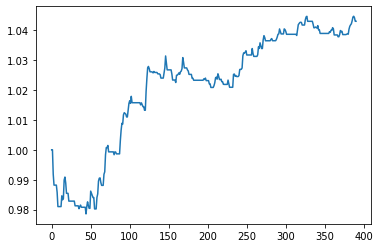

In [34]:
load_bars("1Min", "2021-07-19", "2021-07-19")
spy = pd.read_csv("C:/Users/Student/Analytics Projects/AlpacaStream/data_files/bar_files/min/{}.txt".format("NIO"), header=0)
spy["date"] = pd.to_datetime(spy["date"], utc=True)
spy = spy.set_index("date")
spy = spy.between_time('13:30', '20:00')
spy['log_returns'] = log_returns(spy['close'])
with_vwap = vwap(spy, 5)
with_vwap['vwap_indicator'] = vwap_buy(with_vwap['close'], with_vwap['vwap_{}'.format(5)])
day_rets = intra_day_returns(with_vwap)
plt.plot(np.exp(day_rets))
day_rets[-10:]
#print(day_rets)
#plt.plot(spy['close'][150:200])
#plt.plot(spy['vwap_5'][150:200])
#plt.plot(day_rets)

In [47]:
practice = pd.DataFrame([[1,2,3], [4,5,6]], columns = ['a', 'b', 'c'])
practice['a'].to_numpy()
print(np.sum(practice['b'] * practice['a']))


22


In [56]:
pd.to_datetime("today") < pd.to_datetime("12:00")

False